# Check calculations on TSE(R,S)

When reading the exchange with Thomas Varley, he says that the complete correlation between TSE and S, R remains unclear because the individual atoms can be negative (and thus oppositely correlate). It could therefore be true that the TSE(R,S) structure behaves like I observe, all increasing with synchronization. To strengthen this conclusion, we should confirm further if the TSE calculation is correct and the redundancy and synergy calculations are correct. 
-	We can check the R and S values first by plotting histograms for the TC and MI values and see if our intuition indeed confirms the R and S values. 
-	If this works, we can further check the R and S values by performing a calculation similar to the causal decomposition, like below in (https://www.nature.com/articles/s41467-024-53373-4#Sec20): 
-	We can check the TSE calculation by performing a second calculation using the dit.multivariate library (https://dit.readthedocs.io/en/latest/measures/multivariate/tse_complexity.html)


Import one Kuramoto example and divide into two parts. First 1000 points should be, acc. to previous analysis, less synergisic, redundant and TSE complex than the second half.

In [6]:
import infotopo_no_prints
import os
import xgi
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from sklearn.utils import Bunch
from scipy.integrate import solve_ivp
from dit import Distribution
from dit.multivariate import tse_complexity
import itertools

In [14]:
# Simulate Kuramoto model for high order interactions with XGI
def simulate_kuramoto_xgi(H, K2, K3, T=20, dt=0.01):
    timesteps=int(T/dt)
    H_int = xgi.convert_labels_to_integers(H, "label")
    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    n = H_int.num_nodes

    theta_time = np.zeros((timesteps, n))
    times = np.arange(timesteps) * dt

    omega = np.random.normal(0, 1, n)
    theta = np.random.random(n) * 2 * np.pi

    for t in range(timesteps):
        theta_time[t] = theta
        r1 = np.zeros(n, dtype=complex)
        r2 = np.zeros(n, dtype=complex)

        for i, j in links:
            r1[i] += np.exp(1j * theta[j])
            r1[j] += np.exp(1j * theta[i])

        for i, j, k in triangles:
            r2[i] += np.exp(2j * theta[j] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[j])
            r2[j] += np.exp(2j * theta[i] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[i])
            r2[k] += np.exp(2j * theta[i] - 1j * theta[j]) + np.exp(2j * theta[j] - 1j * theta[i])

        d_theta = omega + K2 * np.multiply(r1, np.exp(-1j * theta)).imag + K3 * np.multiply(r2, np.exp(-1j * theta)).imag
        theta_new = theta + d_theta * dt
        theta = theta_new

    frequencies_df = pd.DataFrame(theta_time, index=times)

    return frequencies_df

# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Conversion to compute TSE using dit.multivariate
def convert_tc_dict_to_distribution(TC_dict):
    """
    Constructs a dit.Distribution from a dictionary of total correlations.

    Parameters:
        TC_dict (dict): Dictionary where keys are tuples (subsets of variables) 
                        and values are the corresponding total correlations.

    Returns:
        Distribution: A probability distribution approximated from total correlations.
    """
    # Determine the number of variables (N)
    N = max(max(subset) for subset in TC_dict)  # Find the largest variable index

    # Generate all possible binary states for N variables
    states = list(itertools.product([0, 1], repeat=N))

    # Assign artificial probabilities based on total correlations
    probabilities = []
    
    for state in states:
        total_tc = 0
        for subset in TC_dict:
            subset_indices = [i - 1 for i in subset]  # Convert 1-based to 0-based indices
            if all(0 <= i < N and state[i] == 1 for i in subset_indices):  # Check valid indices
                total_tc += TC_dict[subset]
        probabilities.append(np.exp(-total_tc))  # Exponential scaling

    probabilities = np.array(probabilities)
    probabilities /= probabilities.sum()  # Normalize to make it a valid probability distribution

    # Convert to dit Distribution
    d = Distribution(states, probabilities)

    return d

# Compute TSE complexity using dit.multivariate
def compute_tse_from_tc_dict_using_dit(TC_dict):
    """
    Computes TSE complexity using dit's tse_complexity() function.

    Parameters:
        TC_dict (dict): Dictionary where keys are tuples (subsets of variables) 
                        and values are the corresponding total correlations.

    Returns:
        float: The computed TSE complexity.
    """
    # Convert TC dictionary to a probability distribution
    d = convert_tc_dict_to_distribution(TC_dict)
    
    # Compute TSE complexity using dit
    return tse_complexity(d)

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, dimension_max=0, dimension_tot=0):

    bunch_data = dataframe_to_bunch(df_input)
    Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

    S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
    R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]

    S_mean = sum(S_values)/len(S_values)
    R_mean = sum(R_values)/len(R_values)

    TSE_value_simple = compute_tse_complexity(Nfree_energy)
    TSE_value_dit = compute_tse_from_tc_dict_using_dit(Nfree_energy)
    
    return Ninfomut, Nfree_energy, S_mean, R_mean, TSE_value_simple, TSE_value_dit

In [147]:
# Function to calculate information decomposition following causal inference
def obtain_information_components(dictionary):
    # Extract values based on key length
    keylength_1 = {k: v for k, v in dictionary.items() if len(k) == 1}
    keylength_2 = {k: v for k, v in dictionary.items() if len(k) == 2}
    keylength_greater_1 = {k: v for k, v in dictionary.items() if len(k) > 1}

    # Compute R
    min_value_keylength_2 = min(keylength_2.values())
    R_candidates = {k: v for k, v in keylength_1.items() if v <= min_value_keylength_2}
    R = max(R_candidates.values())

    # Compute U
    max_value_keylength_1 = max(keylength_1.values())
    if (max_value_keylength_1 - R) > 0:
        U = max_value_keylength_1 - R
    else:
        U = 0

    # Compute S
    max_value_keylength_greater_1 = max(keylength_greater_1.values())
    if (max_value_keylength_greater_1 - U) > 0:
        S = max_value_keylength_greater_1 - U
    else:
        S = 0

    return R, U, S

In [44]:
# Parameters
N = 8   # Number of oscillators
K = 3.0  # Coupling strength
T = 20   # Total time
dt = 0.01  # Time step

# Construct an all-to-all pairwise hypergraph (equivalent to a complete graph)
H = xgi.Hypergraph()
H.add_nodes_from(range(N))  # Add nodes
for i in range(N):
    for j in range(i + 1, N):
        H.add_edge([i, j])  # Add all possible pairwise links

# Set k2 = K / N for consistency with the standard Kuramoto model
K2 = K / N
K3 = 0  # No higher-order interactions

# Run the simulation
frequencies_df = simulate_kuramoto_xgi(H, K2, K3, T, dt)

In [150]:
df_input = frequencies_df[:10]
dimension_max = 4
dimension_tot = 8

Ninfomut, Nfree_energy, S_mean, R_mean, TSE_value_simple, TSE_value_dit = interactions_values_relative(df_input, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_13920\1412861841.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  df_input = frequencies_df[:10]


In [151]:
print(TSE_value_simple)
print(TSE_value_dit)

5.159970305906702
0.9248512583267339


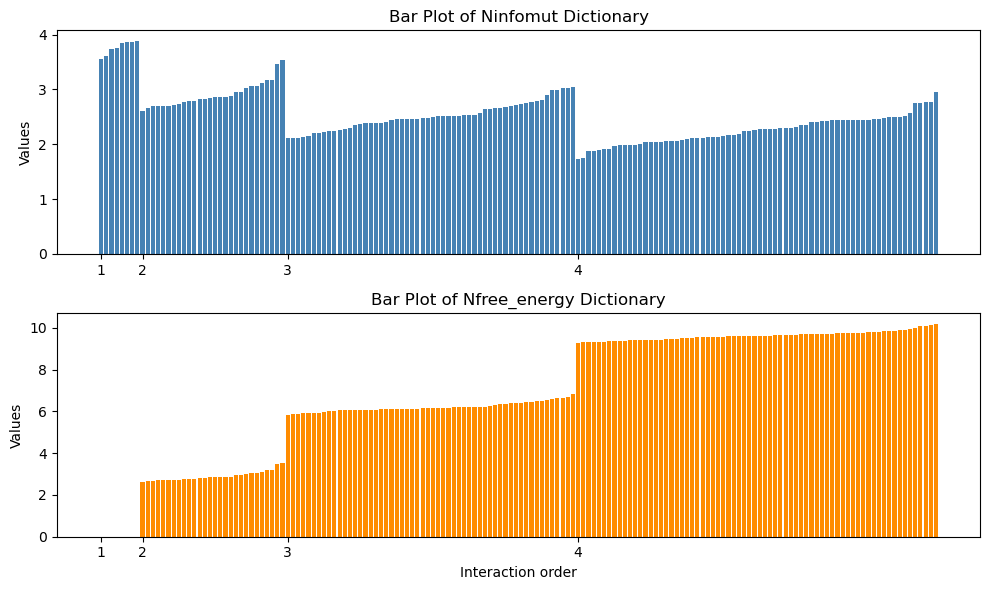

In [152]:
# Function to process dictionary for plotting
def process_data(data):
    sorted_items = sorted(data.items(), key=lambda x: (len(x[0]), x[1]))
    keys_sorted = [item[0] for item in sorted_items]
    values_sorted = [item[1] for item in sorted_items]
    key_labels = [str(k) for k in keys_sorted]
    return key_labels, values_sorted

# Process data
labels_infomut, values_infomut = process_data(Ninfomut)
labels_free_energy, values_free_energy = process_data(Nfree_energy)

# Obtain x-ticks
seen_lengths = set()
indeces = []
keylengths = []

for index, (key, value) in enumerate(Ninfomut.items()):
    key_length = len(key)
    if key_length not in seen_lengths:
        indeces.append(index)
        keylengths.append(f'{key_length}')
        seen_lengths.add(key_length)

# Create figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

# Plot first bar plot
axs[0].bar(labels_infomut, values_infomut, color='steelblue')
axs[0].set_ylabel("Values")
axs[0].set_title("Bar Plot of Ninfomut Dictionary")
axs[0].tick_params(axis='x', bottom=True)  # Hide tick marks
axs[0].set_xticks(indeces)  # Remove x-ticks
axs[0].set_xticklabels(keylengths)  # Remove x-axis labels

# Plot second bar plot
axs[1].bar(labels_free_energy, values_free_energy, color='darkorange')
axs[1].set_ylabel("Values")
axs[1].set_xlabel("Interaction order")
axs[1].set_title("Bar Plot of Nfree_energy Dictionary")
axs[1].tick_params(axis='x', bottom=True)  # Hide tick marks
axs[1].set_xticks(indeces)  # Remove x-ticks
axs[1].set_xticklabels(keylengths)  # Remove x-axis labels

plt.tight_layout()
plt.show()

In [155]:
Redundant_information, Unique_information, Synergistic_information = obtain_information_components(Nfree_energy)

# Print results
print(f"Redundant information: {Redundant_information}")
print(f"Unique information: {Unique_information}")
print(f"Synergistic information: {Synergistic_information}")

print(f'S mean is: {S_mean}')
print(f'R mean is: {R_mean}')

Redundant information: 0.0
Unique information: 0
Synergistic information: 10.199508209781879
S mean is: 2.1374322533951933
R mean is: 4.668796167255022
